<span style="font-size: 16pt; font-weight: bold;">(PSL) Coding Assignment 2</span>





<br>


<br>








Authors:

* Qi Zhou - qizhou8 - MCS-DS

* Yogananth Mahalingam - ym24 - MCS-DS





**Part I: Implement Lasso**

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lm
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [36]:
np.random.seed(4844)


Load Data


In [37]:
myData = pd.read_csv("PSL_data/Coding2_Data.csv")
var_names = myData.columns
y = myData[['Y']].to_numpy()
X = myData.drop(['Y'], axis = 1).to_numpy()

In [38]:
X.shape, len(y)


((506, 13), 506)

CD for Lasso


In [39]:
def one_var_lasso(r, x, lam):

    #################
    # Your CODE
    #################

    # r shape n x 1
    # x shape n x 1
    # lam scaler

    a = np.dot(r.T, x)/np.dot(x.T, x)

    eta = (2*len(r)*lam)/np.dot(x.T, x)

    if a > eta/2:
      beta = a - eta/2
    elif a < - eta/2:
      beta = a + eta/2
    elif abs(a) <= eta/2:
      beta = 0

    return beta


In [40]:
def MyLasso(X, y, lam_seq, maxit = 100):

    # Input
    # X: n-by-p design matrix without the intercept
    # y: n-by-1 response vector
    # lam.seq: sequence of lambda values (arranged from large to small)
    # maxit: number of updates for each lambda

    # Output
    # B: a (p+1)-by-len(lam.seq) coefficient matrix
    #    with the first row being the intercept sequence


    n, p = X.shape
    nlam = len(lam_seq)
    B = np.zeros((p+1, nlam))

    ##############################
    # YOUR CODE:
    # (1) newX = Standardizad X;
    # (2) Record the centers and scales used in (1)
    ##############################

    newX = (X - X.mean(axis=0)) / X.std(axis=0)


    # Initilize coef vector b and residual vector r
    b = np.zeros(p)
    r = y


    # Triple nested loop
    for m in range(nlam):
        for step in range(maxit):
            for j in range(p):
                X_j = newX[:, j].reshape(-1,1)
                r = r + X_j * b[j]
                b[j] = one_var_lasso(r, X_j, lam_seq[m])
                r = r - X_j * b[j]
        B[1:, m] = b

    ##############################
    # YOUR CODE:
    # Scale back the coefficients;
    # Update the intercepts stored in B[, 0]
    ##############################

    orginal_b = B[1:, :].copy()

    B[1:, :] = B[1:, :]/X.std(axis=0).reshape(-1,1)

    y_lam = np.full(len(lam_seq), y.mean())

    B[0,:] = np.full(len(lam_seq), y.mean()) - (np.dot(X.mean(axis=0)/X.std(axis=0),orginal_b))

    return(B)

In [41]:
log_lam_seq = np.linspace(-1, -8, num = 80)
lam_seq = np.exp(log_lam_seq)
myout = MyLasso(X, y, lam_seq, maxit = 100)

(-8.35, -0.6499999999999999, -0.30999458351285203, 0.49974219884805027)

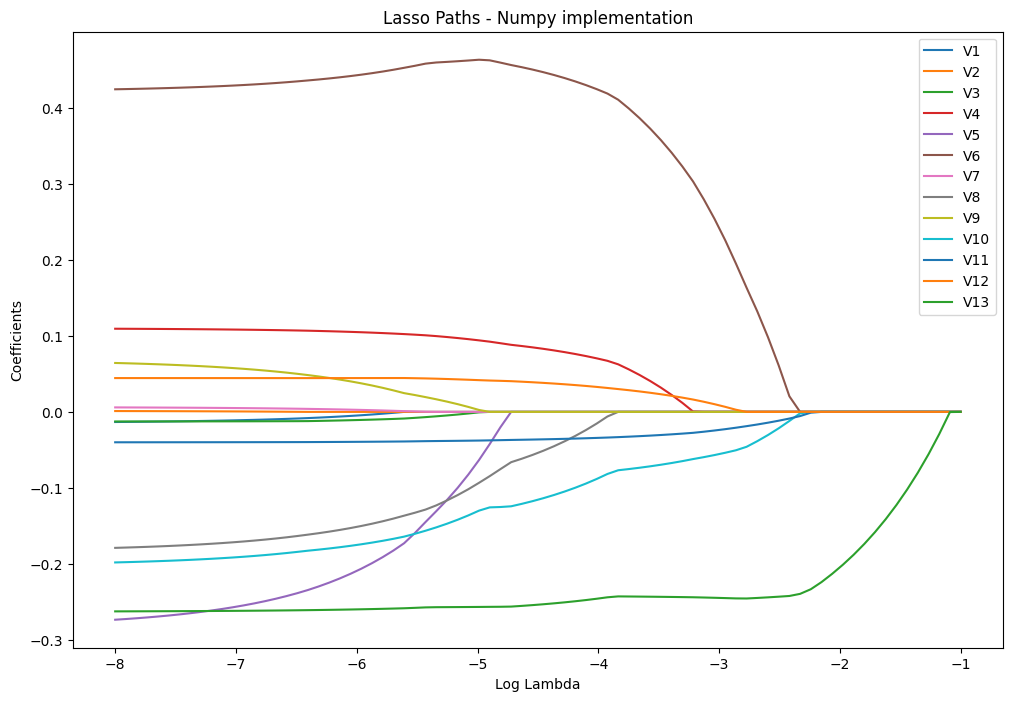

In [42]:
p, _ = myout.shape
plt.figure(figsize = (12,8))

for i in range(p-1):
    plt.plot(log_lam_seq,myout[i+1, :], label = var_names[i])


plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Lasso Paths - Numpy implementation')
plt.legend()
plt.axis('tight')


**Check the Accuracy**

Compare the accuracy of your algorithm against the output from glmnet. The maximum difference between the two coefficient matrices should be less than 0.005.


In [43]:
lasso_coef = pd.read_csv("PSL_data/Coding2_lasso_coefs.csv").to_numpy()
lasso_coef.shape

(14, 80)

In [44]:
abs(myout - lasso_coef).max()


0.004645317415915784

The two coefficient matrices is less than 0.005.


# **Part II: Simulation Study**


In [45]:
def load_data(path):
    myData = pd.read_csv(path)
    Y = myData['Y']
    X = myData.drop(['Y'], axis = 1)

    return X, Y


In [46]:
def preprocess_data(X,Y):

    n = len(Y)
    indices = np.arange(0, n)
    np.random.shuffle(indices)
    test_ind = indices[:int(np.floor(0.25*n))]
    train_ind = indices[len(test_ind):]

    # Splitting the data into training and testing sets
    X_train = X.iloc[train_ind]
    Y_train = Y[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y[test_ind]

    # Create a StandardScaler instance and fit it on the training data,
    # Transform the training data using the fitted scaler and transform the test data using the same scaler

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train,Y_train, X_test, Y_test, X_train_scaled, X_test_scaled


In [47]:
def full_lm(X_train,Y_train,X_test,Y_test):

    full = lm().fit(X_train, Y_train)
    full_mse_error = mean_squared_error(Y_test, full.predict(X_test))

    return full_mse_error

In [48]:
def Ridge_Regression(X_train_scaled,X_test_scaled,Y_train,Y_test):

    ridge_alphas = np.logspace(-10, 1, 100)
    ridgecv = RidgeCV(alphas = ridge_alphas, cv = 10,
                      scoring = 'neg_mean_squared_error')
    ridgecv.fit(X_train_scaled, Y_train)
    ridge_model = Ridge(alpha = ridgecv.alpha_)
    ridge_model.fit(X_train_scaled, Y_train)
    Ridge_mse_err = mean_squared_error(Y_test, ridge_model.predict(X_test_scaled))

    return Ridge_mse_err


In [49]:
def lasso(X_train_scaled,X_test_scaled,Y_train,Y_test):

    lasso_alphas = np.logspace(-10, 1, 100)
    lassocv = LassoCV(alphas = lasso_alphas, cv = 10)
    lassocv.fit(X_train_scaled, Y_train)

    mean_mse = np.mean(lassocv.mse_path_, axis=1)
    std_mse = np.std(lassocv.mse_path_, axis=1) / np.sqrt(10)
    cv_alphas = lassocv.alphas_
    min_idx = np.argmin(mean_mse)
    alpha_min = cv_alphas[min_idx]
    threshold = mean_mse[min_idx] + std_mse[min_idx]
    alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

    #### alpha_min
    lasso_model_min = Lasso(alpha = alpha_min, max_iter=10000)
    lasso_model_min.fit(X_train_scaled, Y_train)
    alpha_min_mse_err = mean_squared_error(Y_test, lasso_model_min.predict(X_test_scaled))

    #### alpha_1se
    lasso_model_1se = Lasso(alpha = alpha_1se, max_iter=10000)
    lasso_model_1se.fit(X_train_scaled, Y_train)
    alpha_1se_mse_err = mean_squared_error(Y_test, lasso_model_1se.predict(X_test_scaled))

    return alpha_min_mse_err,alpha_1se_mse_err, lasso_model_1se



In [50]:
def Refit_lasso(lasso_model_1se,X_train,Y_train,X_test,Y_test):
    nonzero_indices = np.where(lasso_model_1se.coef_ != 0)[0]
    lm_refit = lm()
    lm_refit.fit(X_train.iloc[:, nonzero_indices], Y_train)
    refit_1m_mse_err = mean_squared_error(Y_test, lm_refit.predict(X_test.iloc[:, nonzero_indices]))

    return refit_1m_mse_err


In [51]:
class PCR(object):

    def __init__(self, num_folds=10):
        self.folds = num_folds

    def fit(self, X, Y):
        n, p = X.shape
        indices = np.arange(n)
        np.random.shuffle(indices)
        index_sets = np.array_split(indices, self.folds)
        ncomp = min(p, n - 1 - max([len(i) for i in index_sets]))
        cv_err = np.zeros(ncomp)

        for ifold in range(self.folds):
            train_inds =  np.delete(index_sets, obj=ifold, axis=0).ravel()
            test_inds = index_sets[ifold]

            X_train = X[train_inds, :]
            pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA())])
            pipeline.fit(X_train)
            X_train = pipeline.transform(X_train)
            coefs = Y[train_inds].T @ X_train / np.sum(X_train**2, axis=0)
            b0 = np.mean(Y[train_inds])

            X_test = pipeline.transform(X[test_inds, :])

            for k in np.arange(ncomp):
                preds = X_test[:, :k] @ coefs.T[:k] + b0
                cv_err[k] += cv_err[k] + np.sum((Y[test_inds]-preds)**2)

        min_ind = np.argmin(cv_err)
        self.ncomp = min_ind+1
        pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=self.ncomp))])
        self.transform = pipeline.fit(X)
        self.model = lm().fit(self.transform.transform(X), Y)

    def predict(self, X):
        X_ = self.transform.transform(X)
        return self.model.predict(X_)

## **Case I**

Download Coding2_Data2.csv. The first 14 columns are the same as the data set we used in Part I with Y being the response variable (moved to the 1st column). The additional 78 more predictors are the quadratic and interaction terms of the original 13 predictors.


In [52]:

# [a] Conduct the following simulation exercise 50 times

path = "PSL_data/Coding2_Data2.csv"

X,Y = load_data(path)

MSPE1 = np.zeros((50, 6))

for i in tqdm(range(50)):

    X_train,Y_train, X_test, Y_test, X_train_scaled, X_test_scaled = preprocess_data(X,Y)

    full_mse_error = full_lm(X_train,Y_train,X_test,Y_test)
    MSPE1[i, 0] = full_mse_error


    Ridge_mse_err = Ridge_Regression(X_train_scaled,X_test_scaled,Y_train,Y_test)
    MSPE1[i, 1] = Ridge_mse_err


    alpha_min_mse_err,alpha_1se_mse_err, lasso_model_1se = lasso(X_train_scaled,X_test_scaled,Y_train,Y_test)
    MSPE1[i,2] = alpha_min_mse_err
    MSPE1[i,3] = alpha_1se_mse_err


    refit_1m_mse_err = Refit_lasso(lasso_model_1se,X_train,Y_train,X_test,Y_test)
    MSPE1[i,4] = refit_1m_mse_err


    pcr = PCR()
    pcr.fit(X_train.to_numpy(), Y_train.to_numpy())
    PCR_mse_err = mean_squared_error(Y_test, pcr.predict(X_test.to_numpy()))
    MSPE1[i,5] = PCR_mse_err


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [07:31<00:00,  9.04s/it]


In [53]:
MSPE1_file_path = 'PSL_data/MSPE1.npy'

# Save the MSPE
np.save(MSPE1_file_path, MSPE1)

MSPE1 = np.load(MSPE1_file_path)



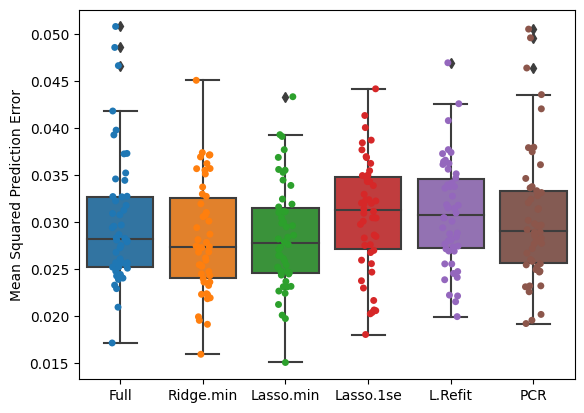

In [54]:
# [b] Graphically summarize findings on the MSPE using a strip chart with a boxplot overlay.

fig, ax = plt.subplots()

bp1 = sns.boxplot(data=MSPE1)
g1 = sns.stripplot(data=MSPE1, ax=ax)

xtick_labels = np.array(["Full", "Ridge.min", "Lasso.min", "Lasso.1se", "L.Refit", "PCR"])
g1.set_xticks(range(xtick_labels.shape[0]), xtick_labels)
ax.set_ylabel('Mean Squared Prediction Error')


plt.show()

**Which procedure or procedures yield the best performance in terms of MSPE?**

Both Ridget.min and Lasso.min  appear to exhibit the best performance in terms of MSPE because the boxplot shows that the medians of their MSPE values are the lowest among all the procedures, with Lasso.min having a more tightly packed IQR compared to Ridget.min.


**Conversely, which procedure or procedures show the poorest performance?**

Both Lasso.ise and L.Refit seem to produce the poorest performance with respect to MSPE as the boxplot displayes that their MSPE medians are comparably the highest among all the methods, and their IQR show a similar spread.


**In the context of Lasso regression, which procedure, Lasso.min or Lasso.1se, yields a better MSPE?**

Lasso.min yields a better MSPE, as indicated by the boxplot that the IQR of Lasso.min's MSPE is on a lower end compared to Lasso.1se. 


**Is refitting advantageous in this case? In other words, does L.Refit outperform Lasso.1se?**

L.Refit appears to outperform Lasso.1se with lower MSPE's median and more compact IQR. 


**Is variable selection or shrinkage warranted for this particular dataset? To clarify, do you find the performance of the Full model to be comparable to, or divergent from, the best-performing procedure among the other five?**

The Full model appears to perform less effectively than both Ridget.min, which applies variable shrinkage, and Lasso.min, which conducts variable selection, this simulation study suggests that both variable selection and shrinkage techniques are justified for this specific dataset.

# **Case II**

Download Coding2_Data3.csv. The first 92 columns are identical to those in Coding2_Data2.csv,
with the addition of 500 columns of artificially generated noise features.

In [55]:

# [a] Conduct the following simulation exercise 50 times. Repeat [a] and [b] above for the five procedures excluding the Full procedure.

file_path2 = 'PSL_data/Coding2_Data3.csv'

X2,Y2 = load_data(file_path2)

MSPE2 = np.zeros((50, 5))

for i in tqdm(range(50)):

    X_train,Y_train, X_test, Y_test, X_train_scaled, X_test_scaled = preprocess_data(X2,Y2)


    Ridge_mse_err = Ridge_Regression(X_train_scaled,X_test_scaled,Y_train,Y_test)
    MSPE2[i, 0] = Ridge_mse_err

    alpha_min_mse_err,alpha_1se_mse_err, lasso_model_1se = lasso(X_train_scaled,X_test_scaled,Y_train,Y_test)
    MSPE2[i,1] = alpha_min_mse_err
    MSPE2[i,2] = alpha_1se_mse_err

    refit_1m_mse_err = Refit_lasso(lasso_model_1se,X_train,Y_train,X_test,Y_test)
    MSPE2[i,3] = refit_1m_mse_err


    pcr = PCR()
    pcr.fit(X_train.to_numpy(), Y_train.to_numpy())
    PCR_mse_err = mean_squared_error(Y_test, pcr.predict(X_test.to_numpy()))
    MSPE2[i,4] = PCR_mse_err



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [27:35<00:00, 33.10s/it]


In [56]:
MSPE2_file_path = 'PSL_data/MSPE2.npy'

# Save the MSPE
np.save(MSPE2_file_path, MSPE2)

MSPE2 = np.load(MSPE2_file_path)

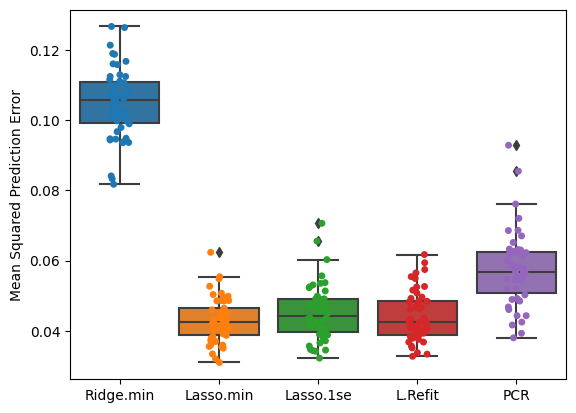

In [57]:
# [b] Graphically summarize findings on the MSPE using a strip chart with a boxplot overlay.

fig, ax = plt.subplots()

bp2 = sns.boxplot(data=MSPE2)
g2 = sns.stripplot(data=MSPE2, ax=ax)

xtick_labels = np.array(["Ridge.min", "Lasso.min", "Lasso.1se", "L.Refit", "PCR"])
g2.set_xticks(range(xtick_labels.shape[0]), xtick_labels)
ax.set_ylabel('Mean Squared Prediction Error')


plt.show()



**Which procedure or procedures yield the best performance in terms of MSPE?**

Lasso.min appears to yield the best performance in terms of MSPE with lower MSPE's median and more compact IQR, as shown in the boxplot.


**Conversely, which procedure or procedures show the poorest performance?**

Ridge.min appears to yield the poorest performance in terms of MSPE because the plot shows that its MSPE is notably greater than that of all the other procedures.


**Have you observed any procedure or procedures that performed well in Case I but exhibited poorer performance in Case II, or vice versa? If so, please offer an explanation.**

Ridge.min performed well in Case I but exhibited poorer performance in Case II. This outcome is expected because Case II involves the introduction of 500 noise features into the dataset, which can have a detrimental effect on model performance. In this scenario, the use of denoising techniques becomes essential. Ridge.min, which solely provides variable shrinkage, can result in high MSP in the presence of noisy features.

**Given that Coding2_Data3.csv includes all features found in Coding2_Data2.csv, one might anticipate that the best MSPE in Case II would be equal to or lower than the best MSPE in Case I. Do your simulation results corroborate this expectation? If not, please offer an explanation.**

My simulation results do not corroborate this expectation because the best MSPE in Case II is slightly above 0.04, while the best MSPE in Case II is lower than 0.03, as shown in the plot. One possible explanation is that while Coding2_Data3.csv encompasses all the features present in Coding2_Data2.csv, it introduces an extra set of 500 noise features into the dataset. Even when employing Lasso.min, which incorporates a feature selection technique, it's possible that the 500 noise features are not completely eliminated. Consequently, this could lead to a higher MSPE.

